# 異常検知基礎講座 通し課題

### ハワイには年に数回、例外的に大きな波が来るという。その異常値ともいうべき波を、「外れ値検出」を用い、どの程度の頻度・大きさで発生するかを確かめる。
### この大波を事前に予測できれば、波を狙ったサーファーをハワイに呼び寄せることが出来て、ハワイの観光業も潤い、サーファーの満足度を高めることも出来る。
### 予測にあたっては、ハワイの波が生まれる場所の一つと言われるオホーツク海の気象情報を用いる。オホーツク海の異常気象がハワイの大波を引き起こすとの仮定に基づき、「外れ値検出」を用いオホーツク海の異常を検出し、ハワイの大波を予測する。

### ハワイの波の情報を取得する
#### • USのNational Weather Serviceより、オアフ島北部ワイメアビーチの波の情報を取得する。(2018年1月初ー11月末の1時間ごとの情報)
#### ftp://polar.ncep.noaa.gov/pub/history/waves/multi_1/

In [12]:
# import required libraries
import pandas as pd
import pandas.tseries.offsets as offsets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats #統計に関するライブラリ
from IPython.core.display import display 
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Data is downloaded and ready to use!
# 51201はワイメアビーチの観測地点を指す記号
df_data = pd.read_csv("./data/51201/connected.tsv", sep=' ')
print("Row lengths of imported data: ", len(df_data))

Row lengths of imported data:  8026


In [13]:
#まずはHeaderを確認
display(df_data.head())
df_data = df_data.rename(columns={'Unnamed: 0': 'dummy', '2018': 'year', '1': 'month', '1.1': 'day', '0': 'hour', 
                                  '3.8': 'wind_speed','75': 'wind_direction','1.5': 'wave_height','13.9': 'peak_period'})
df_data = df_data.drop(['dummy', 'peak_period'], axis=1)
display(df_data.head())
df_data.describe()
print('波の高さは平均で1.4m、95%（±2σ）の波は2.54m以下であるが、最大は5.8mとかなり大きい！')

,Unnamed: 0,2018,1,1.1,0,3.8,75,1.5,13.9
0,NaN,2018,1,1,1,4.3,75,1.5,13.9
1,NaN,2018,1,1,2,4.8,76,1.5,13.9
2,NaN,2018,1,1,3,5.4,77,1.5,13.8
3,NaN,2018,1,1,4,5.1,78,1.5,13.8
4,NaN,2018,1,1,5,4.9,80,1.5,13.7


,year,month,day,hour,wind_speed,wind_direction,wave_height
0,2018,1,1,1,4.3,75,1.5
1,2018,1,1,2,4.8,76,1.5
2,2018,1,1,3,5.4,77,1.5
3,2018,1,1,4,5.1,78,1.5
4,2018,1,1,5,4.9,80,1.5


波の高さは平均で1.4m、95%（±2σ）の波は2.54m以下であるが、最大は5.8mとかなり大きい！


#### 日付の編集



In [15]:
# 日付を日単位、時間単位で編集
df_data_wave = df_data.copy()

df_data_wave['datetime_str'] = df_data_wave['year'].astype(str) \
                             + df_data_wave['month'].astype(str).str.zfill(2) \
                             + df_data_wave['day'].astype(str).str.zfill(2) \
                             + ' ' + df_data_wave['hour'].astype(str).str.zfill(2)
df_data_wave['datetime_'] = pd.to_datetime(df_data_wave['datetime_str'], format='%Y%m%d %H')
df_data_wave['date_str'] = df_data_wave['year'].astype(str) \
                             + df_data_wave['month'].astype(str).str.zfill(2) \
                             + df_data_wave['day'].astype(str).str.zfill(2)
df_data_wave['date_'] = pd.to_datetime(df_data_wave['date_str'], format='%Y%m%d')
df_data_wave = df_data_wave.drop(['year','month','day','hour','datetime_str','date_str','wind_direction'], axis=1)
display(df_data_wave.head())

,wind_speed,wave_height,datetime_,date_
0,4.3,1.5,2018-01-01 01:00:00,2018-01-01
1,4.8,1.5,2018-01-01 02:00:00,2018-01-01
2,5.4,1.5,2018-01-01 03:00:00,2018-01-01
3,5.1,1.5,2018-01-01 04:00:00,2018-01-01
4,4.9,1.5,2018-01-01 05:00:00,2018-01-01


2018年は4-5回、3m超の波が来たようだ


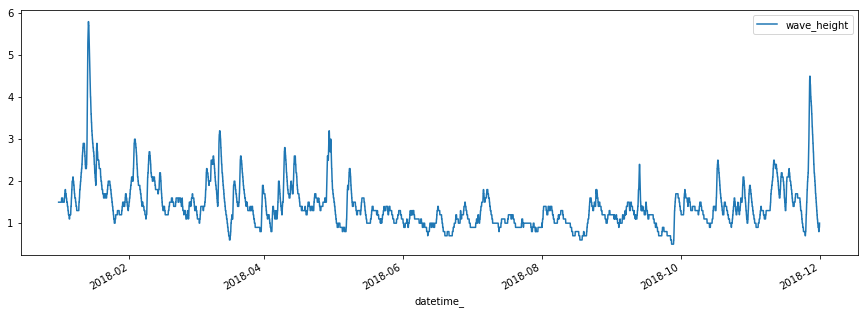

In [16]:
# 日付と波の高さのグラフを描く
df_data_wave.plot(x=df_data_wave.columns[2], y=df_data_wave.columns[1], kind='line', figsize=(15,5))
print("2018年は4-5回、3m超の波が来たようだ")

,wind_speed,wave_height,datetime_,date_,score
0,4.3,1.5,2018-01-01 01:00:00,2018-01-01,0.702808
1,4.8,1.5,2018-01-01 02:00:00,2018-01-01,0.702808
2,5.4,1.5,2018-01-01 03:00:00,2018-01-01,0.702808
3,5.1,1.5,2018-01-01 04:00:00,2018-01-01,0.702808
4,4.9,1.5,2018-01-01 05:00:00,2018-01-01,0.702808


確率密度では異常度があまり際立たない


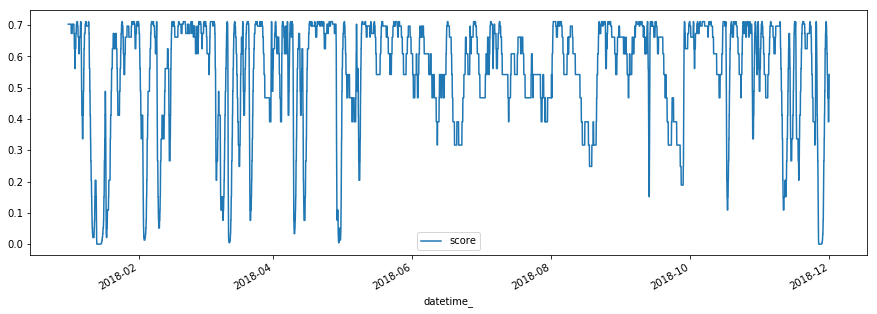

In [17]:
# 確率密度の小ささで異常度を観る
muhat = df_data_wave["wave_height"].mean()
sigmahat = df_data_wave["wave_height"].std(ddof=0)
df_data_wave['score'] = stats.norm.pdf(df_data_wave["wave_height"], loc=muhat, scale=sigmahat)
display(df_data_wave.head())
df_data_wave.plot(x=df_data_wave.columns[2], y=df_data_wave.columns[4], kind='line', figsize=(15,5))
print('確率密度では異常度があまり際立たない')

,wind_speed,wave_height,datetime_,date_,score,ascore
0,4.3,1.5,2018-01-01 01:00:00,2018-01-01,0.702808,0.352671
1,4.8,1.5,2018-01-01 02:00:00,2018-01-01,0.702808,0.352671
2,5.4,1.5,2018-01-01 03:00:00,2018-01-01,0.702808,0.352671
3,5.1,1.5,2018-01-01 04:00:00,2018-01-01,0.702808,0.352671
4,4.9,1.5,2018-01-01 05:00:00,2018-01-01,0.702808,0.352671


異常値が見やすくなった、キリが良いので5以上を異常値とする


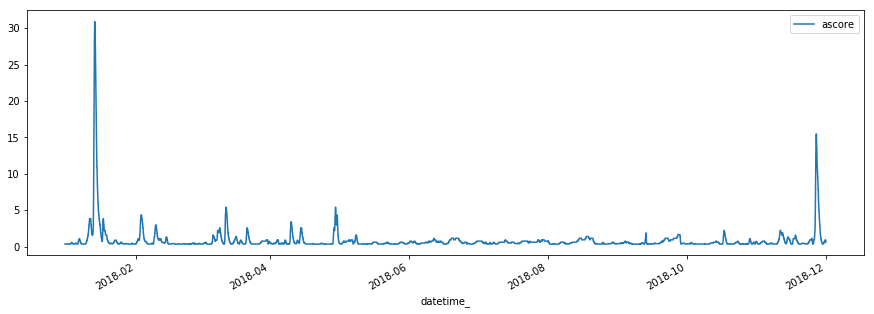

In [18]:
# 情報量で異常度を観る
df_data_wave['ascore'] = - np.log(df_data_wave["score"])
display(df_data_wave.head())
df_data_wave.plot(x=df_data_wave.columns[2], y=df_data_wave.columns[5], kind='line', figsize=(15,5))
print('異常値が見やすくなった、キリが良いので5以上を異常値とする')

In [19]:
# 上記グラフより情報量が5を超えているデータを異常値として抽出する
print(df_data_wave[df_data_wave['ascore'] > 5])
print('データ数が多すぎて、よく分からない')

      wind_speed  wave_height           datetime_      date_         score  \
301          2.8          3.4 2018-01-13 14:00:00 2018-01-13  1.347407e-03   
302          3.1          3.7 2018-01-13 15:00:00 2018-01-13  1.757967e-04   
303          2.9          4.0 2018-01-13 16:00:00 2018-01-13  1.723111e-05   
304          2.6          4.2 2018-01-13 17:00:00 2018-01-13  3.124951e-06   
305          2.4          4.5 2018-01-13 18:00:00 2018-01-13  1.901648e-07   
306          2.7          4.8 2018-01-13 19:00:00 2018-01-13  8.693757e-09   
307          3.0          5.0 2018-01-13 20:00:00 2018-01-13  9.482449e-10   
308          3.2          5.3 2018-01-13 21:00:00 2018-01-13  2.691425e-11   
309          2.9          5.4 2018-01-13 22:00:00 2018-01-13  7.704315e-12   
310          2.5          5.6 2018-01-13 23:00:00 2018-01-13  5.738977e-13   
311          2.1          5.7 2018-01-14 00:00:00 2018-01-14  1.493424e-13   
312          2.1          5.8 2018-01-14 01:00:00 2018-01-14  3.

In [20]:
# 異常値が多すぎるので日付単位で出力する
print(df_data_wave[df_data_wave['ascore'] > 5].groupby('date_').mean())
print('改めてではあるが、年4回 3～6mの波が来ていることが分かった')

            wind_speed  wave_height         score     ascore
date_                                                       
2018-01-13    2.810000     4.590000  1.543759e-04  17.182702
2018-01-14    1.745833     5.208333  2.163047e-07  23.661781
2018-01-15    2.664706     3.605882  1.127518e-03   8.102580
2018-03-12    6.900000     3.200000  4.468401e-03   5.410725
2018-04-29    2.950000     3.200000  4.468401e-03   5.410725
2018-11-26    2.893333     4.160000  3.602406e-04  12.569790
2018-11-27    4.686957     3.734783  7.897630e-04   9.061926
改めてではあるが、年4回 3～6mの波が来ていることが分かった


### オホーツク海の気象情報を取得する
#### ・気象庁より、オホーツク海を代表し根室の気象情報を取得する。(2018年1月初ー11月末の1時間ごとの情報)
#### https://www.data.jma.go.jp/risk/obsdl/index.php#!table

In [21]:
# 次に北海道・根室の気象情報を取り込む
df_data_2 = pd.read_csv("./data/nemuro/connected.csv")
print("Row lengths of imported data: ", len(df_data_2))

Row lengths of imported data:  8039


In [22]:
#まずはHeaderを確認
df_data_2['datetime_'] = pd.to_datetime(df_data_2['datetime_'], format='%Y/%m/%d %H:00')
df_data_2['date_'] = df_data_2['datetime_'].dt.date
display(df_data_2.head())
df_data_2.describe()
print('異常値として幾つか取れそうであるが、まずは気圧を用いる')

,datetime_,Temperature,rain,wind,wind_direction,air_pressure,sea_preasure,vapor_presure,date_
0,2018-01-01 01:00:00,-0.7,0.0,1.8,E,1016.1,1019.6,3.9,2018-01-01
1,2018-01-01 02:00:00,-1.0,0.0,1.4,E,1016.0,1019.5,4.0,2018-01-01
2,2018-01-01 03:00:00,-0.5,0.0,2.2,E,1015.4,1018.8,4.1,2018-01-01
3,2018-01-01 04:00:00,-0.9,0.0,2.9,E,1015.0,1018.5,4.0,2018-01-01
4,2018-01-01 05:00:00,-0.8,0.0,3.8,E,1014.2,1017.6,4.2,2018-01-01


異常値として幾つか取れそうであるが、まずは気圧を用いる


年に数回、大きく低気圧もしくは高気圧に変化しているのが見て取れる


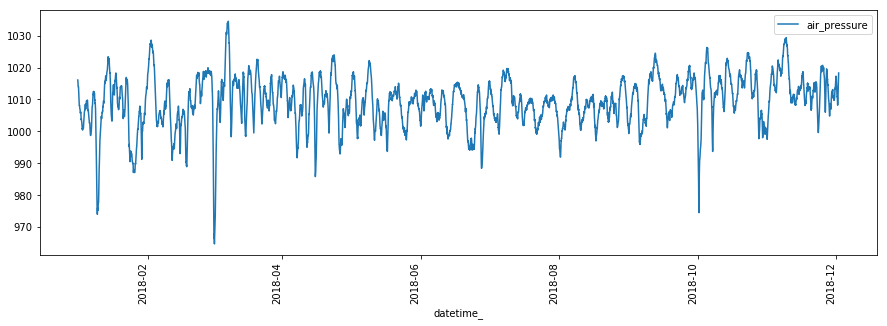

In [23]:
# 根室の気圧変化を見る
df_data_nemuro = df_data_2.copy()
df_data_nemuro = df_data_nemuro.drop(['Temperature','rain','wind_direction','vapor_presure'], axis=1)
df_data_nemuro.plot(x=df_data_nemuro.columns[0], y=df_data_nemuro.columns[2], kind='line', figsize=(15,5), rot=90)
print('年に数回、大きく低気圧もしくは高気圧に変化しているのが見て取れる')

,datetime_,wind,air_pressure,sea_preasure,date_,score
0,2018-01-01 01:00:00,1.8,1016.1,1019.6,2018-01-01,0.035228
1,2018-01-01 02:00:00,1.4,1016.0,1019.5,2018-01-01,0.035609
2,2018-01-01 03:00:00,2.2,1015.4,1018.8,2018-01-01,0.037855
3,2018-01-01 04:00:00,2.9,1015.0,1018.5,2018-01-01,0.039303
4,2018-01-01 05:00:00,3.8,1014.2,1017.6,2018-01-01,0.042042


やはり確率密度では異常度があまり際立たない


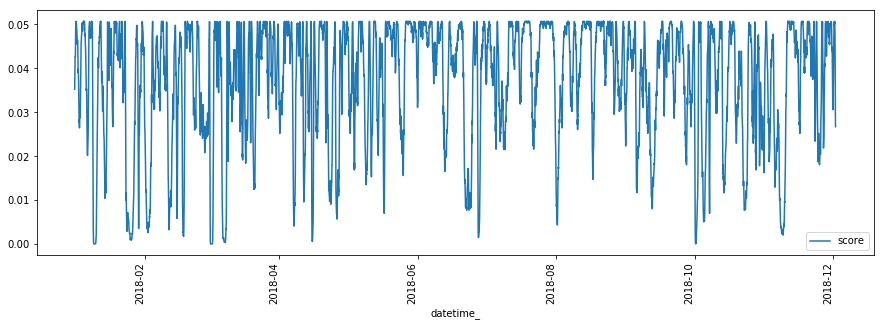

In [24]:
# 確率密度の小ささで異常度を観る
muhat = df_data_nemuro["air_pressure"].mean()
sigmahat = df_data_nemuro["air_pressure"].std(ddof=0)
df_data_nemuro['score'] = stats.norm.pdf(df_data_nemuro["air_pressure"], loc=muhat, scale=sigmahat)
display(df_data_nemuro.head())
df_data_nemuro.plot(x=df_data_nemuro.columns[0], y=df_data_nemuro.columns[5], kind='line', figsize=(15,5), rot=90)
print('やはり確率密度では異常度があまり際立たない')

,datetime_,wind,air_pressure,sea_preasure,date_,score,ascore
0,2018-01-01 01:00:00,1.8,1016.1,1019.6,2018-01-01,0.035228,3.345927
1,2018-01-01 02:00:00,1.4,1016.0,1019.5,2018-01-01,0.035609,3.335167
2,2018-01-01 03:00:00,2.2,1015.4,1018.8,2018-01-01,0.037855,3.273996
3,2018-01-01 04:00:00,2.9,1015.0,1018.5,2018-01-01,0.039303,3.236445
4,2018-01-01 05:00:00,3.8,1014.2,1017.6,2018-01-01,0.042042,3.169094


異常値が見やすくなった、キリがいいので6以上を異常値とする


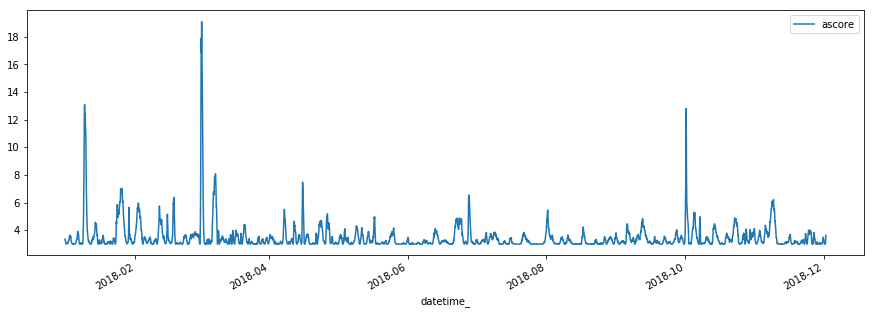

In [25]:
# 情報量で異常度を観る
df_data_nemuro['ascore'] = - np.log(df_data_nemuro["score"])
display(df_data_nemuro.head())
df_data_nemuro.plot(x=df_data_nemuro.columns[0], y=df_data_nemuro.columns[6], kind='line', figsize=(15,5))
print('異常値が見やすくなった、キリがいいので6以上を異常値とする')

In [26]:
# 上記グラフより情報量が6を超えているデータを異常値として抽出する
print(df_data_nemuro[df_data_nemuro['ascore'] > 6])
print('データ数が多すぎて、よく分からない')

               datetime_  wind  air_pressure  sea_preasure       date_  \
198  2018-01-09 07:00:00   6.3         988.9         992.2  2018-01-09   
199  2018-01-09 08:00:00   6.2         986.7         990.0  2018-01-09   
200  2018-01-09 09:00:00   5.9         983.9         987.2  2018-01-09   
201  2018-01-09 10:00:00   6.3         982.0         985.3  2018-01-09   
202  2018-01-09 11:00:00   4.7         979.4         982.7  2018-01-09   
203  2018-01-09 12:00:00   4.2         976.6         979.9  2018-01-09   
204  2018-01-09 13:00:00   2.9         975.2         978.5  2018-01-09   
205  2018-01-09 14:00:00   3.4         975.1         978.4  2018-01-09   
206  2018-01-09 15:00:00   9.2         974.8         978.0  2018-01-09   
207  2018-01-09 16:00:00   8.7         974.0         977.3  2018-01-09   
208  2018-01-09 17:00:00   9.2         974.9         978.2  2018-01-09   
209  2018-01-09 18:00:00   8.0         975.5         978.8  2018-01-09   
210  2018-01-09 19:00:00   7.1        

In [27]:
# 異常値が多すぎるので日付単位で出力する
print(df_data_nemuro[df_data_nemuro['ascore'] > 6].groupby('date_').mean())
print('年9回ほど基本的には低気圧に大きく変動していることが分かった')

                 wind  air_pressure  sea_preasure     score     ascore
date_                                                                 
2018-01-09   7.164706    977.923529    981.217647  0.000176  11.133807
2018-01-10  12.392857    981.550000    984.850000  0.000429   9.415430
2018-01-25   7.721053    988.410526    991.821053  0.001534   6.542386
2018-01-26   8.400000    988.407692    991.807692  0.001547   6.545168
2018-02-17   2.525000    989.525000    992.925000  0.002106   6.166961
2018-02-18   3.150000    989.250000    992.650000  0.001931   6.256124
2018-03-01  14.583333    976.366667    979.650000  0.000177  12.176914
2018-03-02  11.142857    972.009524    975.300000  0.000079  14.638219
2018-03-07   3.270588   1031.629412   1035.164706  0.001034   6.992491
2018-03-08   3.312500   1032.931250   1036.468750  0.000713   7.481371
2018-04-15   8.566667    987.633333    990.933333  0.001235   6.817759
2018-06-27   4.614286    988.900000    992.100000  0.001722   6.370858
2018-0

### ハワイの波とオホーツク海の関連を見る
#### • 関連性が見れれば、オホーツク海の異常気象により、ハワイの波の異常値を観測できる

,wind_speed,wave_height,datetime_,date__x,score_x,ascore_x,wind,air_pressure,sea_preasure,date__y,score_y,ascore_y
0,4.3,1.5,2018-01-01 01:00:00,2018-01-01,0.702808,0.352671,1.8,1016.1,1019.6,2018-01-01,0.035228,3.345927
1,4.8,1.5,2018-01-01 02:00:00,2018-01-01,0.702808,0.352671,1.4,1016.0,1019.5,2018-01-01,0.035609,3.335167
2,5.4,1.5,2018-01-01 03:00:00,2018-01-01,0.702808,0.352671,2.2,1015.4,1018.8,2018-01-01,0.037855,3.273996
3,5.1,1.5,2018-01-01 04:00:00,2018-01-01,0.702808,0.352671,2.9,1015.0,1018.5,2018-01-01,0.039303,3.236445
4,4.9,1.5,2018-01-01 05:00:00,2018-01-01,0.702808,0.352671,3.8,1014.2,1017.6,2018-01-01,0.042042,3.169094


ハワイもオホーツク海も1月に大きなピークがあり、数日の誤差があるように見える。オホーツク海の異常気象の数日後にハワイに大波が来るのではないかと仮定。


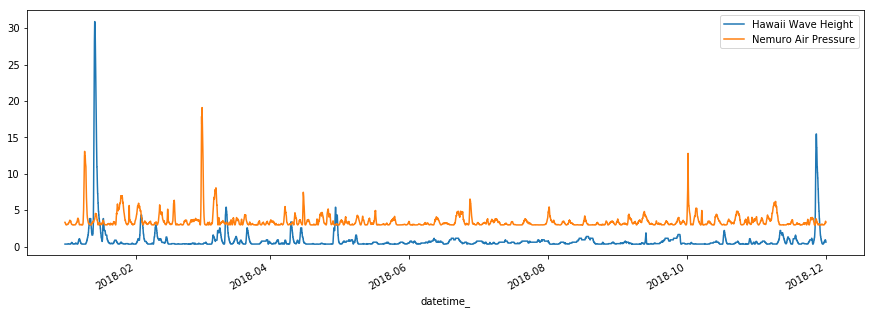

In [28]:
# まずはマージしてみる
df_merged = pd.merge(df_data_wave, df_data_nemuro, on='datetime_')
display(df_merged.head())
#、グラフに描く
df_data_nemuro_tmp = df_data_nemuro.copy()
df_merged = pd.merge(df_data_wave, df_data_nemuro_tmp, on='datetime_')
df_merged = df_merged.drop(['wind_speed','wave_height','date__x','score_x','wind','air_pressure','sea_preasure','date__y','score_y'], axis=1)
df_merged = df_merged.rename(columns={'ascore_x': 'Hawaii Wave Height', 'ascore_y': 'Nemuro Air Pressure'})
df_merged.plot(x=df_merged.columns[0], kind='line', figsize=(15,5))
print('ハワイもオホーツク海も1月に大きなピークがあり、数日の誤差があるように見える。オホーツク海の異常気象の数日後にハワイに大波が来るのではないかと仮定。')

In [29]:
#相関係数を見るためのテスト
df_merged = pd.merge(df_data_wave, df_data_nemuro, on='datetime_')
print(df_merged[['ascore_x','ascore_y']].corr())
print(df_merged[['ascore_x','ascore_y']].corr().at['ascore_x','ascore_y'])

          ascore_x  ascore_y
ascore_x  1.000000  0.003963
ascore_y  0.003963  1.000000
0.00396335594907


In [30]:
# 日付の加算のテスト
df_data_nemuro_tmp = df_data_nemuro.copy()
display(df_data_nemuro_tmp.head())
df_data_nemuro_tmp['datetime_'] = df_data_nemuro_tmp['datetime_'] + offsets.Hour(1)
display(df_data_nemuro_tmp.head())

,datetime_,wind,air_pressure,sea_preasure,date_,score,ascore
0,2018-01-01 01:00:00,1.8,1016.1,1019.6,2018-01-01,0.035228,3.345927
1,2018-01-01 02:00:00,1.4,1016.0,1019.5,2018-01-01,0.035609,3.335167
2,2018-01-01 03:00:00,2.2,1015.4,1018.8,2018-01-01,0.037855,3.273996
3,2018-01-01 04:00:00,2.9,1015.0,1018.5,2018-01-01,0.039303,3.236445
4,2018-01-01 05:00:00,3.8,1014.2,1017.6,2018-01-01,0.042042,3.169094


,datetime_,wind,air_pressure,sea_preasure,date_,score,ascore
0,2018-01-01 02:00:00,1.8,1016.1,1019.6,2018-01-01,0.035228,3.345927
1,2018-01-01 03:00:00,1.4,1016.0,1019.5,2018-01-01,0.035609,3.335167
2,2018-01-01 04:00:00,2.2,1015.4,1018.8,2018-01-01,0.037855,3.273996
3,2018-01-01 05:00:00,2.9,1015.0,1018.5,2018-01-01,0.039303,3.236445
4,2018-01-01 06:00:00,3.8,1014.2,1017.6,2018-01-01,0.042042,3.169094


相関が最大となるのは 107 時間後、値は 0.363444023437
オホーツク海の異常気象の4日と11時間後に、ハワイに大波が出現している


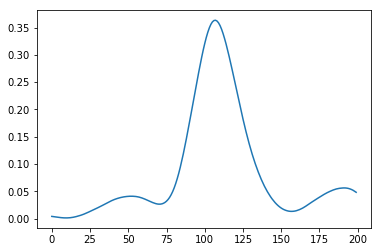

In [31]:
# 根室の気象状況を数時間ずらしたとき、ハワイの波と根室の気象の情報量の相関係数を見る
df_data_nemuro_tmp = df_data_nemuro.copy()
hs_ = []
corrs_ = []
max_corr = 0
max_h = 0
for h in range(0,200,1):
    df_merged = pd.merge(df_data_wave, df_data_nemuro_tmp, on='datetime_')
    corr_ = df_merged[['ascore_x','ascore_y']].corr().at['ascore_x','ascore_y']
    hs_.append(h)
    corrs_.append(corr_)
    if(corr_>max_corr):
        max_corr=corr_
        max_h=h
    df_data_nemuro_tmp['datetime_'] = df_data_nemuro_tmp['datetime_'] + offsets.Hour(1)
# 結果を表示
plt.plot(hs_, corrs_)
print('相関が最大となるのは', max_h,'時間後、値は',max_corr)
print('オホーツク海の異常気象の4日と11時間後に、ハワイに大波が出現している')

オホーツク海の気象情報量を107時間シフトすると、ハワイの波の情報量がいくつかのポイントで重なった


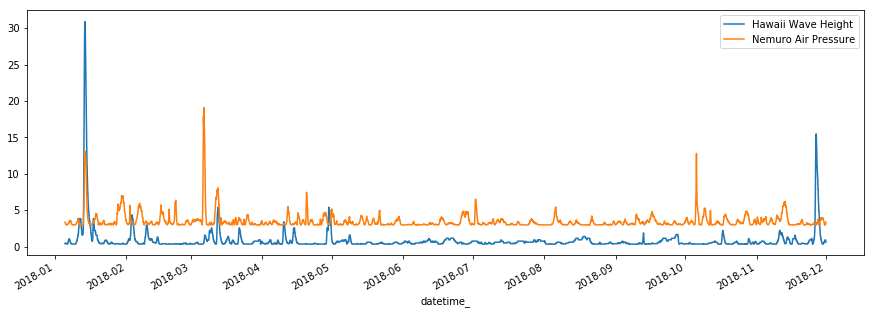

In [32]:
# ハワイの波の情報量と根室の気象状況を107時間分シフトさせ、グラフに描いてみる
df_data_nemuro_tmp = df_data_nemuro.copy()
df_data_nemuro_tmp['datetime_'] = df_data_nemuro_tmp['datetime_'] + offsets.Hour(max_h)
df_merged = pd.merge(df_data_wave, df_data_nemuro_tmp, on='datetime_')
df_merged = df_merged.drop(['wind_speed','wave_height','date__x','score_x','wind','air_pressure','sea_preasure','date__y','score_y'], axis=1)
df_merged = df_merged.rename(columns={'ascore_x': 'Hawaii Wave Height', 'ascore_y': 'Nemuro Air Pressure'})
df_merged.plot(x=df_merged.columns[0], kind='line', figsize=(15,5))
print('オホーツク海の気象情報量を107時間シフトすると、ハワイの波の情報量がいくつかのポイントで重なった')

### 課題
#### ・ピークが107時間の前後で現れているケースがある。前後する要因は何だろうか？
#### ・オホーツク海の異常気象がハワイの大波とならないケース、オホーツク海の異常気象無しにハワイに大波となるケースがある。要因は何だろうか？